### Scene classification based cloud table based on forest inventory data plots from 2012 (table name: 'etrs89_bwi_2012p')

In [11]:
# load packages
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
import datacube
import psycopg2
import folium
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
from functools import partial 

#from utils.data_cube_utilities.cloud_coverage import s2_clean_mask, s2_cct
from odc.ui import with_ui_cbk

# PostGIS connection credentials
user = 'dc_user'
password = 'localuser1234'
host = '127.0.0.1'
port = '5432'
database = 'datacube'

dc = datacube.Datacube(app = 'bavaria_one', config = '/home/datacube/.datacube.conf')

In [12]:
# additional functions

def unpack_s2bits(s2_scl_endcoding, data_array, cover_type):
    boolean_mask = np.isin(data_array.values, s2_scl_endcoding[cover_type]) 
    return xr.DataArray(boolean_mask.astype(bool),
                        coords = data_array.coords,
                        dims = data_array.dims,
                        name = cover_type + "_mask",
                        attrs = data_array.attrs)

def s2_unpack_scl(data_array , cover_type):
    s2_scl_endcoding = dict(no_data                       =[0],
                                saturated_or_defective        =[1],
                                dark_area_pixels              =[2],
                                cloud_shadows                 =[3],
                                vegetation                    =[4],
                                not_vegetated                 =[5],
                                water                         =[6],
                                unclassified                  =[7],
                                cloud_medium_probability      =[8],
                                cloud_high_probability        =[9],
                                thin_cirrus                   =[10],
                                snow                          =[11],
                                cloud                         =[3,8,9,10],
                                cloud_free                    =[4,5,6]
                               )
    return unpack_s2bits(s2_scl_endcoding, data_array, cover_type)

def s2_clean_mask(ds, bands):
    masks = [s2_unpack_scl(ds, band) for band in bands]
    return np.logical_or(*masks).values

def s2_cct(dataset):
    times  = list(dataset.time.values)
    scene_slice_list = list(map(lambda t: dataset.sel(time = t).scl, times))
    clean_mask_list = list(map(partial(s2_clean_mask, bands = ['cloud_free','cloud_free']), scene_slice_list))
    clean_pixel_count_list = list(map(np.sum, clean_mask_list))
    percentage_list = list(map(lambda x:np.sum(x)/(x.shape[0] * x.shape[1]), clean_mask_list))

    data = {"times": times,
            "clean_percentage": percentage_list,
            "clean_count": clean_pixel_count_list }
    
    return pd.DataFrame(data=data, columns = ["times", "clean_percentage", "clean_count"])

In [13]:
# 1. open connection first, 2. write data, 3. close afterwards
connection = psycopg2.connect(database=database, user=user, password=password, host=host)

# choose attributes, e.g. when comparing 
# table =pd.read_sql_query("SELECT  column_name FROM information_schema.columns WHERE table_name = 'etrs89_bwi_2012p';",con=connection )
# with 
# inventory metadata (/Datacube/Forest inventory data/MetadatenFuerTraktdaten.csv for layer-name 'GFs_ReinbestandGattung_mitSp_PolyVar')
# or https://bwi.info/

# sql statement looking for 'geom, tnr, pquerus (percent share oak), pfagus (percent share beech), pfraxinus (percent share ash), 
# pabies (percetn share fir)  ppicea (percent share spruce), ppinus (percetn share pine)'
sql_command = "SELECT geom, tnr, pquerus, pfagus, pfraxinus, pabies, ppicea, ppinus FROM etrs89_bwi_2012p;"
forest_inventory = gpd.GeoDataFrame.from_postgis(sql_command, connection) 
connection.close()

forest_inventory

geom    tnr  pquerus  \
0     MULTIPOLYGON (((597233.574 5241596.664, 597233...      8    0.000   
1     MULTIPOLYGON (((595210.408 5243571.865, 595210...     11    0.000   
2     MULTIPOLYGON (((599205.778 5243622.840, 599205...     12    0.000   
3     MULTIPOLYGON (((593187.241 5245547.065, 593187...     14    0.000   
4     MULTIPOLYGON (((597182.612 5245598.041, 597182...     15    0.000   
...                                                 ...    ...      ...   
2837  MULTIPOLYGON (((620849.021 5575961.846, 620849...  57436    0.697   
2838  MULTIPOLYGON (((660823.100 5577490.897, 660823...  57441    0.000   
2839  MULTIPOLYGON (((622875.212 5573988.618, 622875...  57463    0.000   
2840  MULTIPOLYGON (((626926.597 5570043.163, 626926...  57505    0.000   
2841  MULTIPOLYGON (((654904.453 5571412.382, 654904...  57508    0.000   

      pfagus  pfraxinus  pabies  ppicea  ppinus  
0      0.313      0.000     0.0   0.020   0.000  
1      0.097      0.000     0.0   0.903   0.000  
2      0.000      0.000     0.0   0.160   0.000  
3      0.000      0.000     0.0   0.333   0.000  
4      0.513      0.121     0.0   0.366   0.000  
...      ...        ...     ...     ...     ...  
2837   0.024      0.000     0.0   0.000   0.000  
2838   0.000      0.000     0.0   0.358   0.000  
2839   0.000      0.000     0.0   0.000   1.000  
2840   0.000      0.000     0.0   0.000   0.492  
2841   0.000      0.000     0.0   0.000   0.000  

[2842 rows x 8 columns]

In [14]:
# transform for plotting on folium-webmap
forest_inventory_wgs = forest_inventory.to_crs('EPSG:4326')
# define map center, ~ center of bavaria
y_center = 49
x_center = 11

#### Excourse: lambda function

In [15]:
# excourse: lambda function, aka anonymous function
# allows writing quick functions without naming them, or writing closures
# e.g.:

# define
def adder(x):
    return lambda y: x + y

# we want to add 5 (i.e. x = 5) and add 995 (i.e. x = 995)
add5 = adder(5)
add995 = adder(995)

# apply
print('Add 5 to 10 =',add5(10), ',', 'Add 995 to 5 =', add995(5))

# we use 'lambda' for appyling styles to the forest_inventory polygons 

Add 5 to 10 = 15 , Add 995 to 5 = 1000


In [16]:
# plot on webmap

# define polygon style
style = {'fillColor': '#ffffffff', 'color': '#000000'}

# open map 'm' with defined center and zomm level
m = folium.Map([y_center,x_center], zoom_start=7.5)#, tiles='Stamen Terrain')
# add shape (geodataframe), change to geojson, use 'lambda' function togehter with defined 'style'
folium.GeoJson(data = forest_inventory_wgs.to_json(), name = 'forest inventory 2012',
               style_function=lambda x: style, 
               tooltip=folium.features.GeoJsonTooltip(fields=['pabies', 'pfagus', 'pfraxinus', 'ppicea', 'ppinus', 'pquerus', 'tnr'], localize=True)).add_to(m)
# load openstreet map
folium.TileLayer('openstreetmap').add_to(m)
# load terrain map
folium.TileLayer('Stamen Terrain').add_to(m)
# load esris satellite map
folium.TileLayer(
        tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
        attr = 'Esri',
        name = 'Esri Satellite',
        overlay = False,
        control = True
       ).add_to(m)
# add lat/lon popup after click on maps
folium.LatLngPopup().add_to(m)
# open layer control in upper right corner of the map
folium.LayerControl().add_to(m)
m
# explore potential areas, using satellite layers for example

In [18]:
# e.g. tract 15156 for a closer look
# get information

aoi = forest_inventory.loc[forest_inventory_wgs['tnr'] == 15156]

x_min = aoi.bounds.iloc[0,0]
x_max = aoi.bounds.iloc[0,2]
y_min = aoi.bounds.iloc[0,1]
y_max = aoi.bounds.iloc[0,3]
aoi_wgs = aoi.to_crs('EPSG:4326')
x_map = aoi_wgs.bounds.iloc[0,0]
y_map = aoi_wgs.bounds.iloc[0,1]
aoi

geom    tnr  pquerus  \
2246  MULTIPOLYGON (((531971.196 5512011.912, 531971...  15156    0.057   

      pfagus  pfraxinus  pabies  ppicea  ppinus  
2246     0.0        0.0     0.0   0.682     0.0

In [19]:
# load bands and scene classification
dataset = dc.load(product = 's2_l2a_bavaria', 
                  x=(x_min, x_max),
                  y=(y_min, y_max),
                  measurements=['scl','nir','red','green','blue'],
                  crs='EPSG:25832',
                  time=('2015-01-01', '2020-09-30'),
                  progress_cbk=with_ui_cbk())

In [5]:
style = {'fillColor': '#cfe063', 'color': '#000000'}
m = folium.Map([y_map, x_map], zoom_start=13)#, tiles='Stamen Terrain')
folium.GeoJson(aoi_wgs.to_json(), style_function=lambda x: style).add_to(m)
folium.TileLayer('openstreetmap').add_to(m)
folium.TileLayer('Stamen Terrain').add_to(m)
folium.TileLayer('openstreetmap').add_to(m)
folium.TileLayer(
        tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
        attr = 'Esri',
        name = 'Esri Satellite',
        overlay = False,
        control = True
       ).add_to(m)
folium.LatLngPopup().add_to(m)
folium.LayerControl().add_to(m)
m

NameError: name 'y_map' is not defined

In [6]:
# defining a function, using the scl for mapping vegetation
# denpendencies, 's2_clean_mask', 
def s2_vegetation(dataset):
    times  = list(dataset.time.values)
    scene_slice_list = list(map(lambda t: dataset.sel(time = t).scl, times))
    clean_mask_list = list(map(partial(s2_clean_mask, bands = ['vegetation','vegetation']), scene_slice_list))
    clean_pixel_count_list = list(map(np.sum, clean_mask_list))
    percentage_list = list(map(lambda x:np.sum(x)/(x.shape[0] * x.shape[1]), clean_mask_list))

    data = {"times": times,
            "veg_percentage": percentage_list,
            "veg_count": clean_pixel_count_list }
    
    return pd.DataFrame(data=data, columns = ["times", "veg_percentage", "veg_count"])

In [7]:
veg_table = s2_vegetation(dataset)

with pd.option_context('display.max_rows', 1000):
    print(veg_table)

NameError: name 'dataset' is not defined

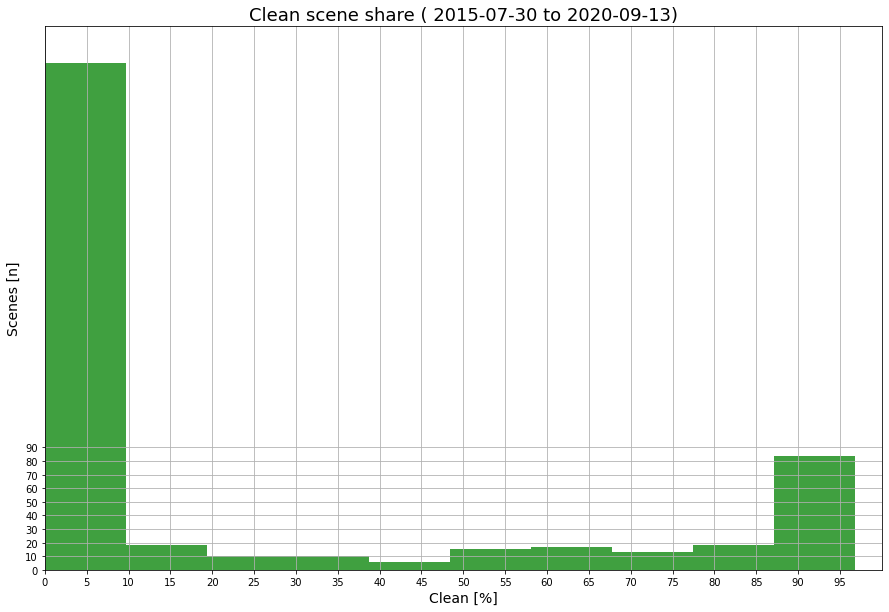

In [11]:
#veg_table = s2_vegetation(dataset)
# get min/max value for axis
# TODO, doin universally, set ticks e.g. with (round(len(veg_table.loc[veg_table['veg_percentage'] <= 0.1])/10)*10)

plt.figure(figsize = (15,10))
#plt.scatter(cloud_table["times"].values, cloud_table["clean_percentage"].values)
plt.hist(veg_table["veg_percentage"]*100, 10, facecolor='g', alpha=.75)
plt.title('Clean scene share ( '+ 
          np.datetime_as_string(dataset.time[0].values).split('T')[0] + " to " +
          np.datetime_as_string(dataset.time[-1].values).split('T')[0] + ")", 
          size='18')

plt.xlabel('Clean [%]', size=14)
plt.ylabel('Scenes [n]', size=14)
plt.yticks(list(range(0,100,10)))
plt.xticks(list(range(0,100,5)))
plt.axis([0,100, 0, 400])
plt.grid(True)
plt.show()

In [12]:
# write vegetation mask
mask = s2_unpack_scl(dataset.scl, 'vegetation')
clean_dataset = dataset.where(mask)

In [13]:
# write ndvi to the two datasets
ndvi = (dataset.nir - dataset.red)/(dataset.nir + dataset.red) 
dataset['ndvi'] = ndvi

ndvi = (clean_dataset.nir - clean_dataset.red)/(clean_dataset.nir + clean_dataset.red) 
clean_dataset['ndvi'] = ndvi


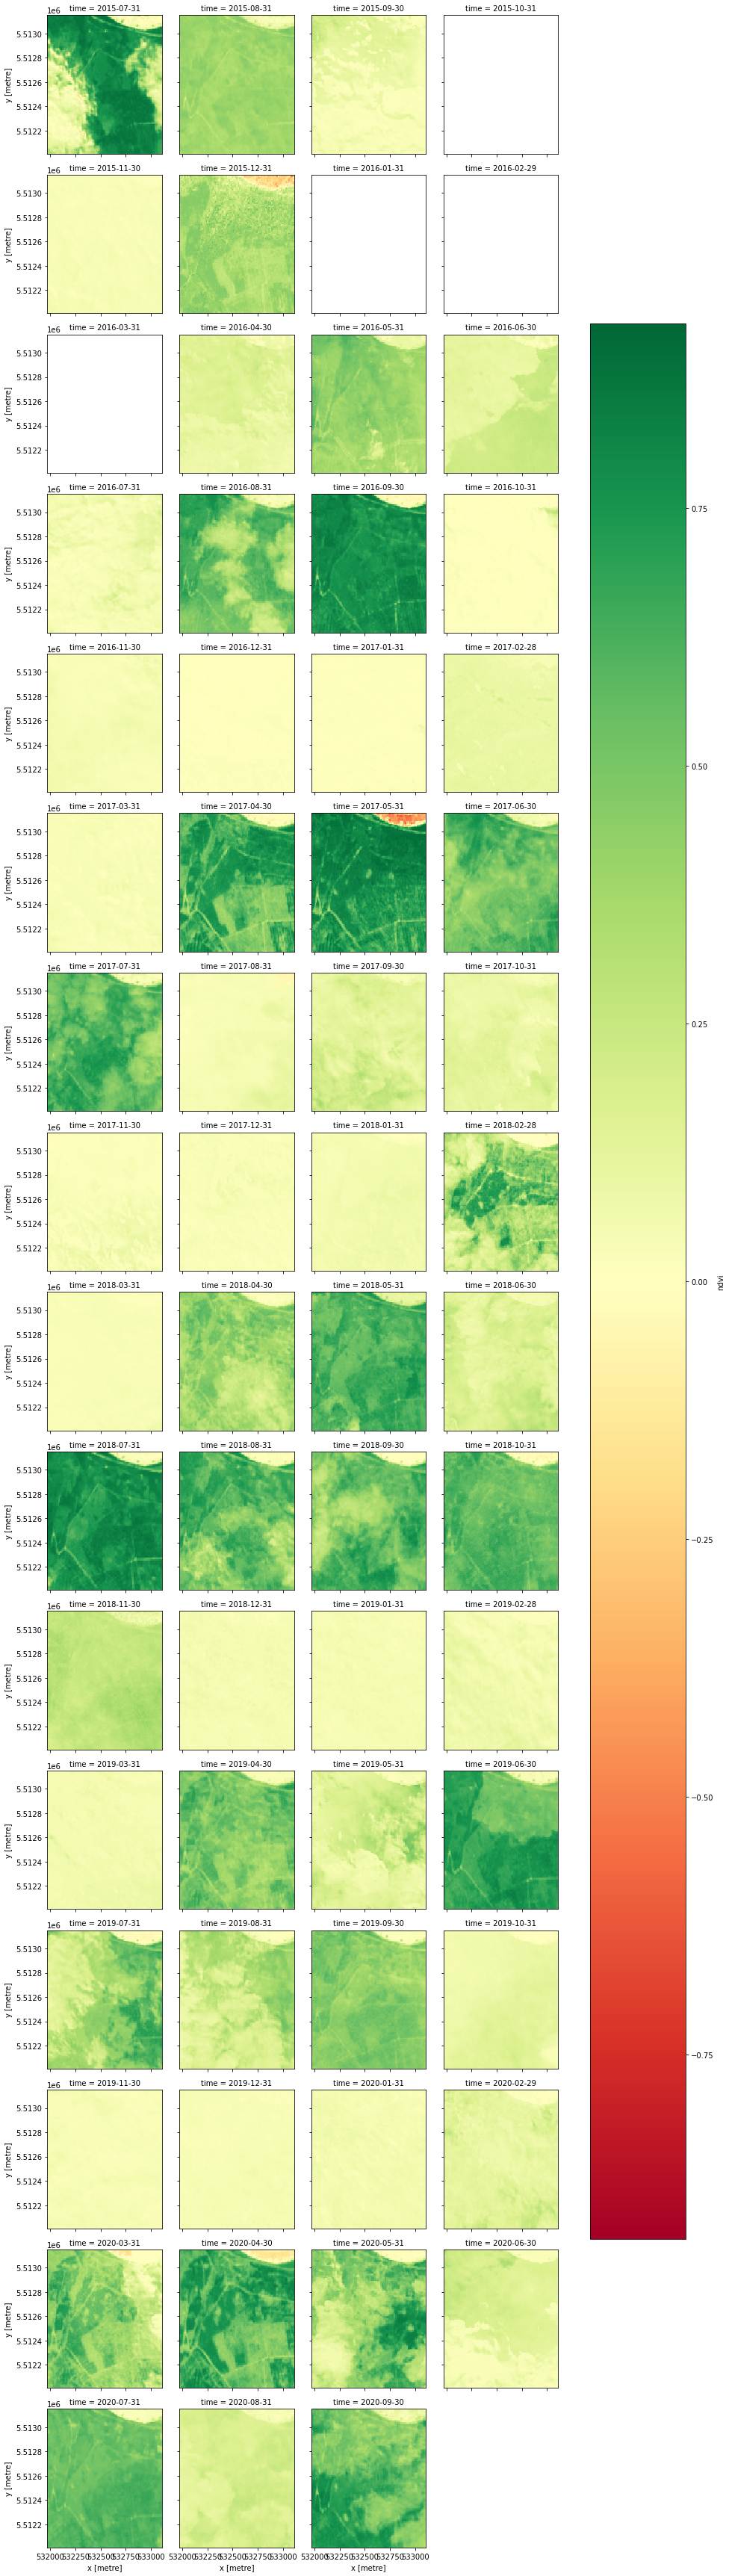

In [14]:
# Resample to combine median composite
ds_resampled = dataset.resample(time='1m').median()
# Plot the new resampled data
ds_resampled.ndvi.plot(col='time', col_wrap=4,cmap='RdYlGn')
plt.show()

/usr/local/lib/python3.6/dist-packages/numpy/lib/nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/usr/local/lib/python3.6/dist-packages/numpy/lib/nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/usr/local/lib/python3.6/dist-packages/numpy/lib/nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/usr/local/lib/python3.6/dist-packages/numpy/lib/nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/usr/local/lib/python3.6/dist-packages/numpy/lib/nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/usr/local/lib/python3.6/dist-packages/numpy/lib/nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/usr/local/lib/python3.6/dist-packages/numpy/lib/nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered

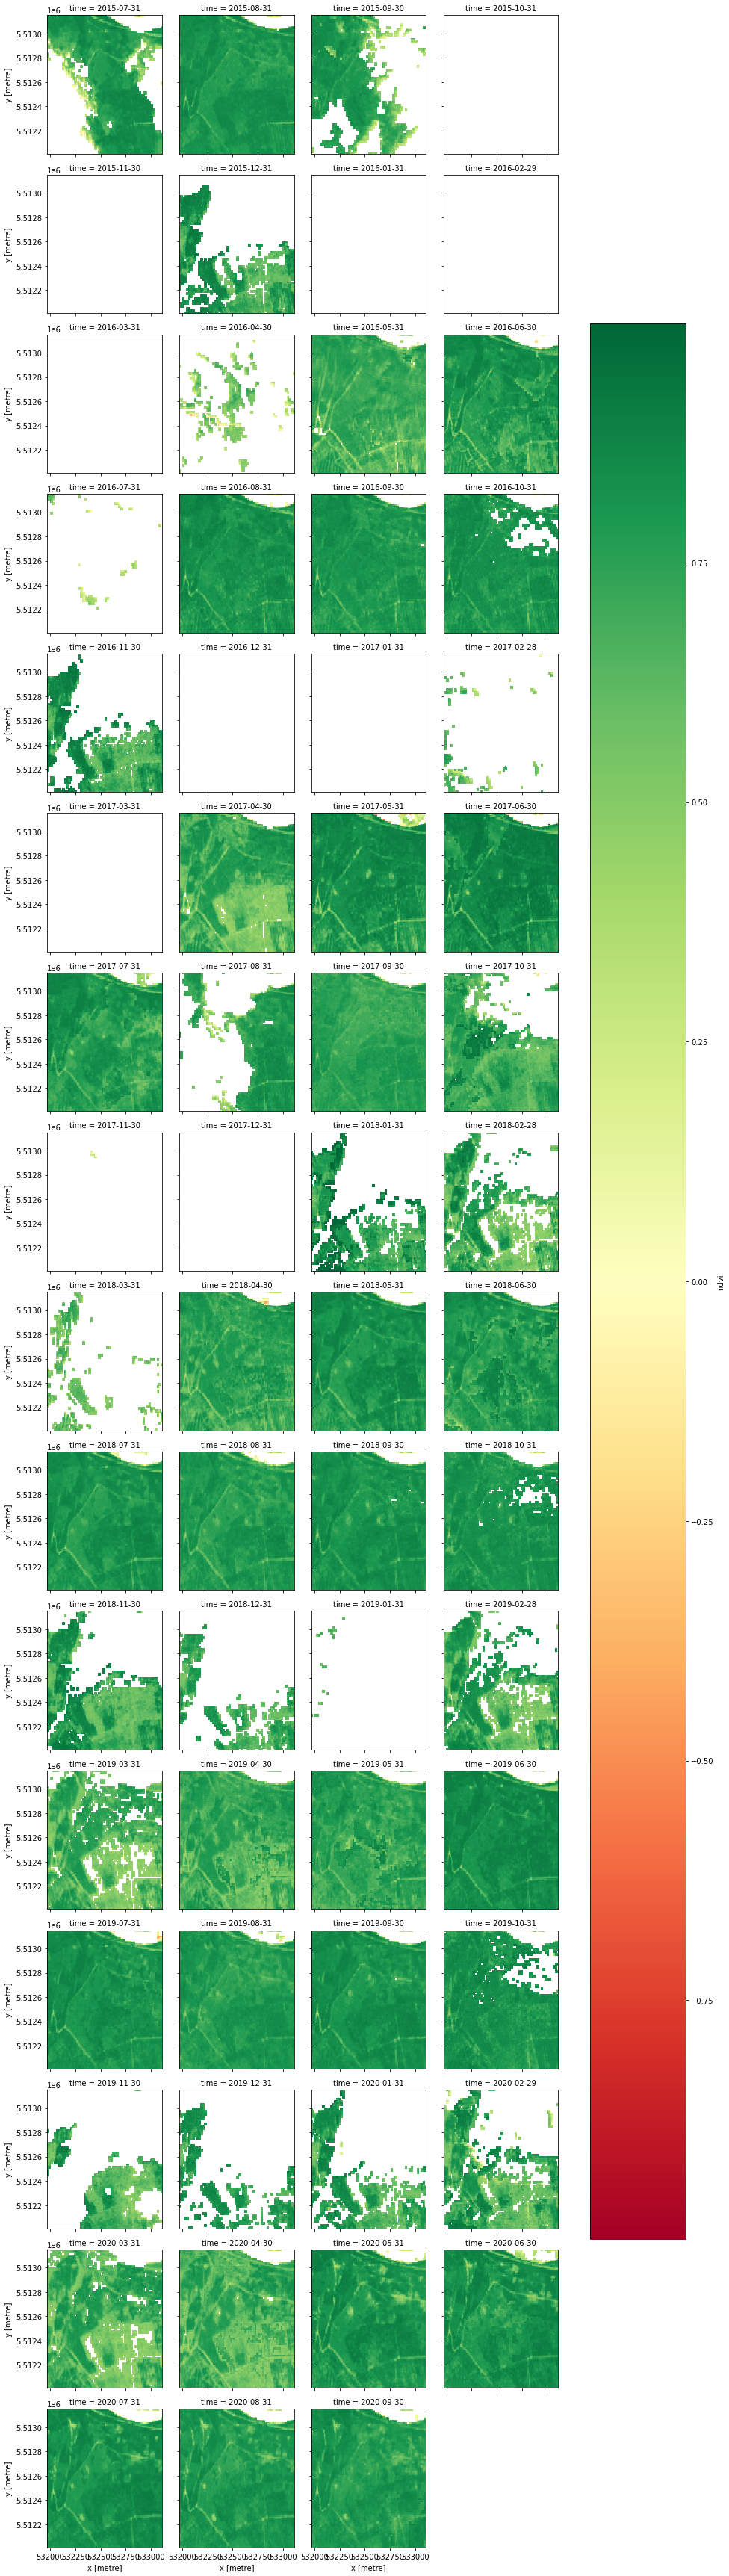

In [15]:
# Resample to combine median composite
ds_resampled = clean_dataset.resample(time='1m').median()
# Plot the new resampled data
ds_resampled.ndvi.plot(col='time', col_wrap=4,cmap='RdYlGn')
plt.show()

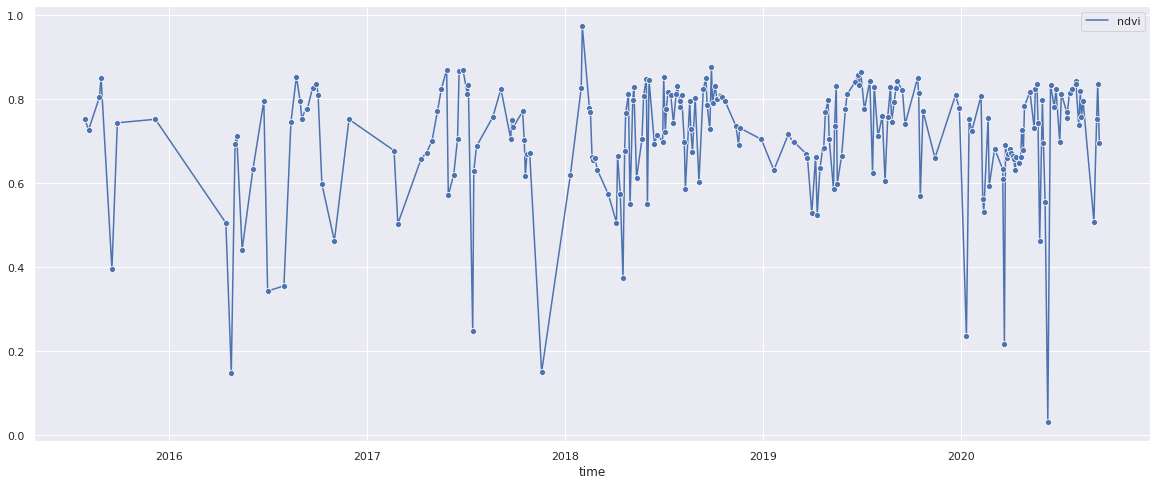

In [16]:
spatial_mean = clean_dataset.mean(dim = ('x', 'y')).to_dataframe()
plot_df = spatial_mean[['ndvi']]

import seaborn as sns

sns.set(style="darkgrid")
ax = plt.figure(figsize=(20,8))
ax = sns.lineplot(data=plot_df,marker="o")

In [50]:
n_pts_smooth = 2000
default_fourier_n_harm = 10

def fourier_fit(x, y, n_predict=0, x_smooth=None, n_pts=n_pts_smooth,
                n_harm=default_fourier_n_harm):
    """
    Creates a Fourier fit of a NumPy array. Also supports extrapolation.
    Credit goes to https://gist.github.com/tartakynov/83f3cd8f44208a1856ce.
    Parameters
    ----------
    x, y: numpy.ndarray
        1D NumPy arrays of the x and y values to fit to.
        Must not contain NaNs.
    n_predict: int
        The number of points to extrapolate.
        The points will be spaced evenly by the mean spacing of values in `x`.
    x_smooth: list-like, optional
        The exact x values to interpolate for. Supercedes `n_pts`.
    n_pts: int, optional
        The number of evenly spaced points spanning the range of `x` to interpolate for.
    n_harm: int
        The number of harmonics to use. A higher value yields a closer fit.
    Returns
    -------
    x_smooth, y_smooth: numpy.ndarray
        The smoothed x and y values of the curve fit.
    """
    if x_smooth is None:
        x_smooth_inds = np.linspace(0, len(x), n_pts)
        x_smooth = np.interp(x_smooth_inds, np.arange(len(x)), x)
    n_predict_smooth = int((len(x_smooth) / len(x)) * n_predict)
    # These points are evenly spaced for the fourier fit implementation we use.
    # More points are selected than are in `x_smooth` so we can interpolate accurately.
    fourier_mult_pts = 2
    x_smooth_fourier = np.linspace(x_smooth.min(), x_smooth.max(),
                                   fourier_mult_pts * len(x_smooth))
    y_smooth_fourier = np.interp(x_smooth_fourier, x, y)
    n_predict_smooth_fourier = int((len(x_smooth_fourier) / len(x)) * n_predict)

    # Perform the Fourier fit and extrapolation.
    n = y_smooth_fourier.size
    t = np.arange(0, n)
    p = np.polyfit(t, y_smooth_fourier, 1)  # find linear trend in arr
    x_notrend = y_smooth_fourier - p[0] * t  # detrended arr
    x_freqdom = fft.fft(x_notrend)  # detrended arr in frequency domain
    f = fft.fftfreq(n)  # frequencies
    # sort indexes by frequency, lower -> higher
    indexes = list(range(n))
    indexes.sort(key=lambda i: np.absolute(x_freqdom[i]))
    indexes.reverse()
    t = np.arange(0, n + n_predict_smooth_fourier)
    restored_sig = np.zeros(t.size)
    for i in indexes[:1 + n_harm * 2]:
        ampli = np.absolute(x_freqdom[i]) / n  # amplitude
        phase = np.angle(x_freqdom[i])  # phase
        restored_sig += ampli * np.cos(2 * np.pi * f[i] * t + phase)
    y_smooth_fourier = restored_sig + p[0] * t

    # Find the points in `x_smooth_fourier` that are near to points in `x_smooth`
    # and then interpolate the y values to match the new x values.
    x_smooth = x_smooth_fourier[np.searchsorted(x_smooth_fourier, x_smooth)]
    # Ensure `x_smooth` includes the extrapolations.
    mean_x_smooth_space = np.diff(x_smooth).mean()
    x_predict_smooth = np.linspace(x_smooth[-1] + mean_x_smooth_space,
                                   x_smooth[-1] + mean_x_smooth_space * n_predict_smooth,
                                   n_predict_smooth)
    x_smooth = np.concatenate((x_smooth, x_predict_smooth))
    # Ensure `x_smooth_fourier` includes the extrapolations.
    mean_x_smooth_fourier_space = np.diff(x_smooth).mean()
    x_predict_smooth_fourier = \
        np.linspace(
            x_smooth_fourier[-1] + mean_x_smooth_fourier_space,
            x_smooth_fourier[-1] + mean_x_smooth_fourier_space * n_predict_smooth_fourier,
            n_predict_smooth_fourier)
    x_smooth_fourier = np.concatenate((x_smooth_fourier, x_predict_smooth_fourier))
    y_smooth = np.interp(x_smooth, x_smooth_fourier, y_smooth_fourier)
    return x_smooth, y_smooth

In [1]:
type(plot_df)

NameError: name 'plot_df' is not defined